In [1]:
import numpy as np
from PIL import Image
import time
import matplotlib.pyplot as plt

from process import Process

In [2]:
# image_path_left = './photo/tsukuba_l.png'
# image_path_right = './photo/tsukuba_r.png'
# image_path_left = './photo/ambush_5_left.jpg'
# image_path_right = './photo/ambush_5_right.jpg'
# image_path_left = './photo/im0.png'
# image_path_right = './photo/im1.png'
image_paths = ['./photo/myszka01.jpg', './photo/myszka02.jpg', './photo/myszka03.jpg']

In [3]:
images = []
for path in image_paths:
    image = Process(path)
    image.resize_image(357, 250)
    images.append(image.get_array())
    image.get_info()
# imL = Process(image_path_left)
# imL.resize_image(357, 250)
# arrL = imL.get_array()
# imL.get_info()

# imR = Process(image_path_right)
# imR.resize_image(357, 250)
# arrR = imR.get_array()
# imR.get_info()

Image size: (357, 250)
Image mode: L
Image size: (357, 250)
Image mode: L
Image size: (357, 250)
Image mode: L


In [4]:

def disp(arrL, arrR):
    from scipy import ndimage

    # activate for laplacian filter
    arrL_filtered = ndimage.laplace(arrL)
    arrR_filtered = ndimage.laplace(arrR)

    array_left = arrL
    array_right = arrR
    """
    Calculate Disparity using shit i tried earlier
    """
    import cv2

    wsizeV3 = 7
    max_dispV3 = 160
    wls_lambdaV3 = 8000
    wls_sigmaV3 = 1.5

    left_matcherV3 = cv2.StereoSGBM_create()
    wls_filterV3 = cv2.ximgproc.createDisparityWLSFilter(left_matcherV3)
    right_matcherV3 = cv2.ximgproc.createRightMatcher(left_matcherV3)


    def getDispV3(imgL, imgR):
        left_for_matcher = cv2.cvtColor(imgL,  cv2.COLOR_BGR2GRAY)
        right_for_matcher = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)

        left_disp = left_matcherV3.compute(left_for_matcher, right_for_matcher)
        right_disp = right_matcherV3.compute(right_for_matcher, left_for_matcher)

        wls_filterV3.setLambda(wls_lambdaV3)
        wls_filterV3.setSigmaColor(wls_sigmaV3)
        filtered_disp = wls_filterV3.filter(left_disp,imgL,disparity_map_right=right_disp)

        vis = cv2.ximgproc.getDisparityVis(filtered_disp)
        disp = cv2.normalize(vis, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_8U)
        
        # disp2 = np.dstack((disp, disp, disp))
        return disp

    resizeSize = (357, 250)
    imgL = cv2.imread(image_path_left, cv2.IMREAD_COLOR)
    imgR = cv2.imread(image_path_right, cv2.IMREAD_COLOR)
    imgL = cv2.resize(imgL, resizeSize)
    imgR = cv2.resize(imgR, resizeSize)

    disp_matrix = getDispV3(imgL, imgR)
    return disp_matrix

In [5]:
matrixes = []
img_prev = None
for img in images:
    if img_prev is not None:
        matrixes.append(disp(img_prev, img))
    img_prev = img

0 rows completed.
10 rows completed.
20 rows completed.
30 rows completed.
40 rows completed.
50 rows completed.
60 rows completed.
70 rows completed.
80 rows completed.
90 rows completed.
100 rows completed.
110 rows completed.
120 rows completed.
130 rows completed.
140 rows completed.
150 rows completed.
160 rows completed.
170 rows completed.
180 rows completed.
190 rows completed.
200 rows completed.
210 rows completed.
220 rows completed.
230 rows completed.
Total runtime: 43.78590178489685
(239, 346)
0 rows completed.
10 rows completed.
20 rows completed.
30 rows completed.
40 rows completed.
50 rows completed.
60 rows completed.
70 rows completed.
80 rows completed.
90 rows completed.
100 rows completed.
110 rows completed.
120 rows completed.
130 rows completed.
140 rows completed.
150 rows completed.
160 rows completed.
170 rows completed.
180 rows completed.
190 rows completed.
200 rows completed.
210 rows completed.
220 rows completed.
230 rows completed.
Total runtime: 45.

In [6]:
"""
Recycle Bin Image Calibration
_____________________________

Calculate the z-coordinate for each pixel using constants in 'calib.txt'
"""

# z_matrix = np.copy(disp_matrix)

# for i in np.nditer(z_matrix):
#     i = 178.232 * 2945.377 / (i + 170.681)

# z_matrix

"\nRecycle Bin Image Calibration\n_____________________________\n\nCalculate the z-coordinate for each pixel using constants in 'calib.txt'\n"

In [7]:
# plt.imshow(disp_matrix)
# plt.savefig('./data/output/MPL.png')

In [8]:
# """
# Optional: Save matrix in a .pkl file for future usage.
# """

# import pickle

# with open('z.pkl', 'wb') as f:
#     pickle.dump(z_matrix, f)

In [12]:
def postprocess(disp_matrix, image_path_left):
    """
    Post-processing
    _______________

    Take the output matrix from disparity calculations and handle noise and discontinuities.

    Noise:

        - Mode Method: Calculate the mode value in a large window around each pixel; assign to value if exceeds threshold.

        - Threshold Cutoff Method: Flatten any extraneous pixels above a threshold to a preset value.

    Discontinuity:

        - Average Method: Calculate the average in small window around each pixel; assign value if difference between disparity
                        and value exceed a threshold.

    """

    from process import Process

    import pandas as pd
    from scipy import stats

    raw_img = image_path_left

    img = Image.open(raw_img)
    img = img.resize((disp_matrix.shape[1], disp_matrix.shape[0]))
    arr = np.array(img)

    xyzrgb = []

    avg_disp = np.copy(disp_matrix)

    for x in range(disp_matrix.shape[1]):
        for y in range(disp_matrix.shape[0]):

            # MEAN
            avg = np.mean(avg_disp[y-7:y+8, x-7:x+8])
            if avg_disp[y, x] - avg > 5:
                avg_disp[y, x] = avg

            # MODE
            if x > 12 and x < disp_matrix.shape[1] - 23:
                if avg_disp[y, x] > 25:
                    y1 = max(0, y-12)
                    y2 = min(y+13, disp_matrix.shape[0])
                    x1 = max(0, x-12)
                    x2 = min(x+13, disp_matrix.shape[1])
                    mode = stats.mode(avg_disp[y1:y2, x1:x2].flatten())
                    # mode = stats.mode(avg_disp[y-12:y+13, x-12:x+13]).flatten()
                    # print(mode)
                    # print(y-12, y+13, x-12, x+13)
                    # print(avg_disp[:y+13, :x+13])
                    avg_disp[y, x] = mode[0][0]

            # THRESHOLD
            if avg_disp[y, x] > 30:
                avg_disp[y, x] = 25

            z = np.multiply(avg_disp[y, x], 6)
            rgb = arr[y, x].astype(np.float) / 255.0
            # xyzrgb.append([x, y, z, rgb[0], rgb[1], rgb[2]])
            xyzrgb.append([x, y, z, rgb[0], rgb[1], rgb[2]])

    xyzrgbetter = np.array(xyzrgb)

    df = pd.DataFrame(xyzrgb)
    df.columns = ['x', 'y', 'z', 'r', 'g', 'b']
    df.to_csv('./point_cloud.txt', index=False)
    plt.imshow(avg_disp)
    plt.savefig('./disp_MPL.png')
    return xyzrgbetter

/home/hubert/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/hubert/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_10101/2040921384.py:63: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  rgb = arr[y, x].astype(np.float) / 255.0


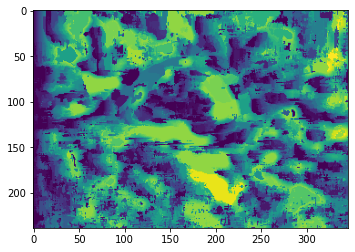

In [13]:
postprocessed = []
postprocessed.append(postprocess(matrixes[0], image_paths[0]))
postprocessed.append(postprocess(matrixes[1], image_paths[1]))

In [14]:
import open3d as o3d


# filename = os.path.join(os.path.abspath(os.path.dirname(__file__)),'z.pkl')
# filename = os.path.join(os.path.abspath(os.path.dirname(__file__)),'point_cloud.txt')
print("Load a ply point cloud, print it, and render it")
# pcd = o3d.io.read_point_cloud("../../TestData/fragment.ply")
# pcd = o3d.io.read_point_cloud(filename, format = 'xyz', remove_nan_points=False, remove_infinite_points=False, print_progress= True)
# pcd = o3d.io.read_point_cloud("./point_cloud.txt", format = 'xyzrgb')
for xyzrgbetter in postprocessed:
    pcd = o3d.geometry.PointCloud()
    xd = xyzrgbetter[:, :3]
    xdd = xyzrgbetter[:, 3:]
    pcd.points = o3d.utility.Vector3dVector(xd)
    pcd.colors = o3d.utility.Vector3dVector(xdd)

    print(pcd)
    print(np.asarray(pcd.points))
    o3d.visualization.draw_geometries([pcd])

    # print("Downsample the point cloud with a voxel of 0.05")
    # downpcd = pcd.voxel_down_sample(voxel_size=0.05)
    # o3d.visualization.draw_geometries([downpcd])

    # print("Recompute the normal of the downsampled point cloud")
    # downpcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(
    #     radius=0.1, max_nn=30))
    # o3d.visualization.draw_geometries([downpcd])

    # print("Print a normal vector of the 0th point")
    # print(downpcd.normals[0])
    # print("Print the normal vectors of the first 10 points")
    # print(np.asarray(downpcd.normals)[:10, :])
    # print("")

    # print("Load a polygon volume and use it to crop the original point cloud")
    # vol = o3d.visualization.read_selection_polygon_volume(
    #     "../../TestData/Crop/cropped.json")
    # chair = vol.crop_point_cloud(pcd)
    # o3d.visualization.draw_geometries([chair])
    # print("")

    # print("Paint chair")
    # chair.paint_uniform_color([1, 0.706, 0])
    # o3d.visualization.draw_geometries([chair])
    # print("")

Load a ply point cloud, print it, and render it
PointCloud with 82694 points.
[[  0.   0.   0.]
 [  0.   1.   0.]
 [  0.   2.   0.]
 ...
 [345. 236. 120.]
 [345. 237. 120.]
 [345. 238.  78.]]
PointCloud with 82694 points.
[[  0.   0.   0.]
 [  0.   1.   0.]
 [  0.   2.   0.]
 ...
 [345. 236.  54.]
 [345. 237.  78.]
 [345. 238.  78.]]
